INITIAL LOAD
Number of documents: 19888


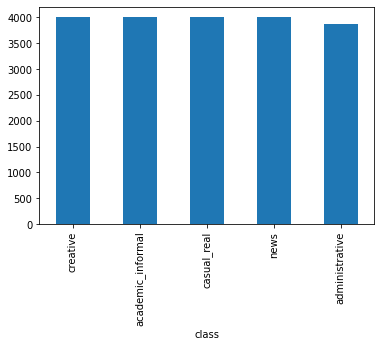

In [6]:
import pandas as pd
import re
from numpy import NaN
from stop_words import get_stop_words
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

from joblib import dump, load

PERCENT_VALID_CHARS_MIN = 0.95

cwd = 'C:/Users/klouc/Desktop/slovcho/style_classification'
df = pd.read_csv(rf"{cwd}/styles.csv",encoding='utf-8')

df["class"].value_counts().plot(kind='bar')

# Initial data load
print("INITIAL LOAD")
print(f"Number of documents: {df['class'].count()}")

In [2]:
# Drop rows with no content
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# After dropping empty documents
print("DROPING EMPTY DOCUMENTS")
print(f"Number of documents: {df['content'].count()}")
print(f"Number of words: {df['content'].apply(lambda x: len(x.split(' '))).sum()}")

DROPING EMPTY DOCUMENTS
Number of documents: 19573
Number of words: 27602510


In [3]:
def clean_document(document):
    replace_with_space_chars = re.compile('[/(){}\[\]\|@,;]')
    # delete_chars = re.compile('[^0-9 #+_]')
    
    stop_words = ['а', 'автентичен', 'аз', 'ако', 'ала', 'бе', 'без', 'беше',
                  'би', 'бивш', 'бивша', 'бившо', 'бил', 'била', 'били', 'било',
                'благодаря', 'близо', 'бъдат', 'бъде', 'бяха', 'в', 'вас', 'ваш',
                'ваша', 'вероятно', 'вече', 'взема', 'ви', 'вие', 'винаги', 'внимава',
                'време', 'все', 'всеки', 'всички', 'всичко', 'всяка', 'във', 'въпреки',
                'върху', 'г', 'ги', 'главен', 'главна', 'главно', 'глас', 'го',
                'година', 'години', 'годишен', 'д', 'да', 'дали', 'два', 'двама',
                'двамата', 'две', 'двете', 'ден', 'днес', 'дни', 'до', 'добра',
                'добре', 'добро', 'добър', 'докато', 'докога', 'дори', 'досега',
                'доста', 'друг', 'друга', 'други', 'е', 'евтин', 'едва', 'един',
                'една', 'еднаква', 'еднакви', 'еднакъв', 'едно', 'екип', 'ето',
                'живот', 'за', 'забавям', 'зад', 'заедно', 'заради', 'засега',
                'заспал', 'затова', 'защо', 'защото', 'и', 'из', 'или', 'им',
                'има', 'имат', 'иска', 'й', 'каза', 'как', 'каква', 'какво',
                'както', 'какъв', 'като', 'кога', 'когато', 'което', 'които',
                'кой', 'който', 'колко', 'която', 'къде', 'където', 'към',
                'лесен', 'лесно', 'ли', 'лош', 'м', 'май', 'малко', 'ме',
                'между', 'мек', 'мен', 'месец', 'ми', 'много', 'мнозина',
                'мога', 'могат', 'може', 'мокър', 'моля', 'момента', 'му',
                'н', 'на', 'над', 'назад', 'най', 'направи', 'напред', 'например',
                'нас', 'не', 'него', 'нещо', 'нея', 'ни', 'ние', 'никой', 'нито',
                'нищо', 'но', 'нов', 'нова', 'нови', 'новина', 'някои', 'някой',
                'няколко', 'няма', 'обаче', 'около', 'освен', 'особено', 'от',
                'отгоре', 'отново', 'още', 'пак', 'по', 'повече', 'повечето', 'под',
                'поне', 'поради', 'после', 'почти', 'прави', 'пред', 'преди', 'през',
                'при', 'пък', 'първата', 'първи', 'първо', 'пъти', 'равен', 'равна', 'с',
                'са', 'сам', 'само', 'се', 'сега', 'си', 'син', 'скоро', 'след', 'следващ',
                'сме', 'смях', 'според', 'сред', 'срещу', 'сте', 'съм', 'със', 'също', 'т',
                'тази', 'така', 'такива', 'такъв', 'там', 'твой', 'те', 'тези', 'ти', 'т.н.',
                'то', 'това', 'тогава', 'този', 'той', 'толкова', 'точно', 'три', 'трябва',
                'тук', 'тъй', 'тя', 'тях', 'у', 'утре', 'харесва', 'хиляди', 'ч', 'часа',
                'че', 'често', 'чрез', 'ще', 'щом', 'юмрук', 'я', 'як']

    # Case fold
    document = document.lower()

    # Replace some chars with space
    document = replace_with_space_chars.sub(' ', document)
    # print(document)

    # Remove some chars entirely
    # document = delete_chars.sub('', document)

    # Remove stop words
    document = ' '.join(word for word in document.split() if word not in stop_words)

    return document

df["content"] = df["content"].apply(lambda x : clean_document(x))

# After pre-processing
print("PRE_PROCESSING DATA")
print(f"Number of documents: {df['content'].count()}")
print(f"Number of words: {df['content'].apply(lambda x: len(x.split(' '))).sum()}")

PRE_PROCESSING DATA
Number of documents: 19573
Number of words: 13121413


In [4]:
# Tf-idf Representation w/ Multinomial Naive Bayes

x = df["content"]
y = df["class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

naive_bayes = Pipeline([
               ('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
naive_bayes.fit(x_train, y_train)

print(naive_bayes.predict(['абе брат какво правиш ти въобще наред ли си']))

dump(naive_bayes, 'style_classification.joblib')
# y_pred = naive_bayes.predict(x_test)

# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=["academic_informal", "administrative", "casual_real", "creative", "news"]))

['casual_real']


['style_classification.joblib']

In [7]:
def classify_style(text):
    classifier = load('style_classification.joblib')
    return classifier.predict([text])

array(['casual_real'], dtype='<U17')